# Spark and S3 Buckets integration demo

**In this demo, we will use a public dataset from libraries in Seattle to see how easy S3 Tables can be used in Spark applications.**

# Spark configuration and namespace configuration.


**First. let's create and configure a Spark session object. Then create a S3 Tables namespace under the table.**


In [ ]:
import logging
import sys
import os
from datetime import datetime
from decimal import Decimal
from IPython.display import display, HTML

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DecimalType, LongType


# Logging configuration
formatter = logging.Formatter('[%(asctime)s] %(levelname)s @ line %(lineno)d: %(message)s')
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
handler.setFormatter(formatter)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(handler)
color = "------------------------- \n\x1b[94;1m"

# Application-specific variables
dt_string = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
AppName = "Demo"

input_csv_path = "s3a://<DATA_SET>/library-checkout/"
s3table_arn = "arn:aws:s3tables:us-west-2:<ACC_NUM>:bucket/demo"

spark = (SparkSession
    .builder
    .appName(f"{AppName}_{dt_string}")
    # Spark S3 Tables library configurations.
    .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    .config("spark.sql.catalog.s3tablesbucket", "org.apache.iceberg.spark.SparkCatalog")
    .config("spark.sql.catalog.s3tablesbucket.catalog-impl", "software.amazon.s3tables.iceberg.S3TablesCatalog")
    .config("spark.sql.catalog.s3tablesbucket.warehouse", s3table_arn)
    .config('spark.hadoop.fs.s3.impl', "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .config("spark.sql.defaultCatalog", "s3tablesbucket")
    .config("spark.hadoop.fs.s3a.connection.timeout", "1200000") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.maximum", "200") \
    .config("spark.hadoop.fs.s3a.fast.upload", "true") \
    .config("spark.hadoop.fs.s3a.readahead.range", "256K") \
    .config("spark.hadoop.fs.s3a.input.fadvise", "random") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider.mapping", "com.amazonaws.auth.WebIdentityTokenCredentialsProvider=software.amazon.awssdk.auth.credentials.WebIdentityTokenFileCredentialsProvider") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", "software.amazon.awssdk.auth.credentials.WebIdentityTokenFileCredentialsProvider")
    .getOrCreate())

namespace = "demo"
table_name = "demo"
full_table_name = f"s3tablesbucket.{namespace}.{table_name}"


In [5]:
# Create a namespace
spark.sql(f"CREATE NAMESPACE IF NOT EXISTS s3tablesbucket.{namespace}")
results = spark.sql("SHOW NAMESPACES;")
display(results.toPandas())


,namespace
0,demo


# Read CSV data from a S3 Bucket

Our example data files store checkout data from [Seattle area libraries](https://data.seattle.gov/Community-and-Culture/Checkouts-by-Title/tmmm-ytt6/about_data) in 2024. Data includes information such as, how many times a book was checked out, when it was checked out, and media type (books, e-books, etc). 
For this demo purposes, they are stored in a S3 Bucket in CSV format. Let's read data from them.


In [13]:
library_checkout = spark.read.options(mode='FAILFAST', multiLine=True, escape='"').csv(input_csv_path, header=True, inferSchema=True)
library_checkout.createOrReplaceTempView("checkout_data")
spark.sql("SELECT * FROM checkout_data LIMIT 2;").toPandas()

,usageclass,checkouttype,materialtype,checkoutyear,checkoutmonth,checkouts,title,isbn,creator,subjects,publisher,publicationyear
0,Digital,OverDrive,AUDIOBOOK,2023,3,1,The Age of Doubt (unabridged),9781481590273,Andrea Camilleri,"Fiction, Mystery","Blackstone Audio, Inc.",2012
1,Digital,OverDrive,AUDIOBOOK,2023,3,1,Boys I Know (unabridged),9780593558829,Anna Gracia,"Romance, Young Adult Fiction, Young Adult Lite...",Books on Tape,2022


# A quick peek 

Let's take a quick look at total usage data by Media Type like books, e-book, etc.

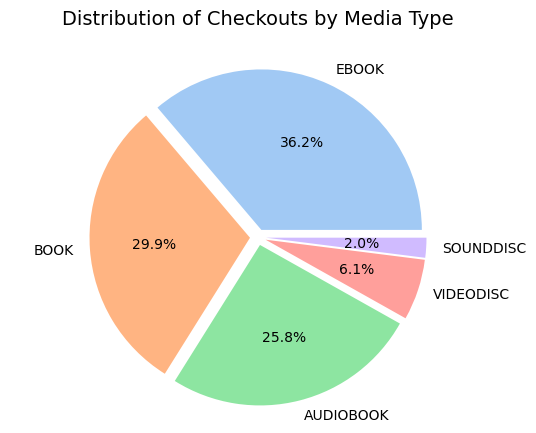

In [21]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter


total_query = """SELECT 
    MaterialType,
    COUNT(*) as total_records,
    SUM(Checkouts) as total_checkouts
FROM checkout_data
GROUP BY MaterialType
ORDER BY total_checkouts DESC;"""

total_result = spark.sql(total_query).toPandas().nlargest(5, "total_checkouts")
plt.pie(total_result['total_checkouts'], 
        labels=total_result['MaterialType'],
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel'),
        explode=[0.05] * 5
       )
plt.axis('equal')
plt.title('Distribution of Checkouts by Media Type', pad=20, size=14)
plt.show()


# Store in S3 Tables

Data looks ok. Let's store it in S3 Tables.

We can write to S3 Tables just like you would to a normal S3 Bucket. E.g. `input_data.writeTo("catalog.db.table").using("Iceberg").Create()`

You can get information about the table with standard queries supported by iceberg. E.g. `SELECT * FROM s3tablesbucket.demo.demo.files`


In [14]:
logger.info(f"Writing data to S3 Tables: {full_table_name}")
library_checkout.writeTo(full_table_name).using("Iceberg").createOrReplace()
logger.info(f"Successfully written data to S3 Tables")

def display_with_header(content, header, level=1):
    header_html = f'<h{level} style="color: #FFB26F"> {header}</h{level}>'
    display(HTML(header_html))
    display(content)

display_with_header(spark.sql("SELECT * FROM s3tablesbucket.demo.demo.files LIMIT 1;").toPandas(), "Iceberg Files", 3)
display_with_header(spark.sql("SELECT * FROM s3tablesbucket.demo.demo.history LIMIT 1;").toPandas(), "Iceberg History", 3)
display_with_header(spark.sql("SELECT * FROM s3tablesbucket.demo.demo.snapshots LIMIT 1;").toPandas(), "Iceberg Snapshots", 3)


[2025-02-28 19:24:08,839] INFO @ line 1: Writing data to S3 Tables: s3tablesbucket.demo.demo
[2025-02-28 19:24:08,839] INFO @ line 1: Writing data to S3 Tables: s3tablesbucket.demo.demo
[2025-02-28 19:24:28,794] INFO @ line 3: Successfully written data to S3 Tables
[2025-02-28 19:24:28,794] INFO @ line 3: Successfully written data to S3 Tables


,content,file_path,file_format,spec_id,record_count,file_size_in_bytes,column_sizes,value_counts,null_value_counts,nan_value_counts,lower_bounds,upper_bounds,key_metadata,split_offsets,equality_ids,sort_order_id,readable_metrics
0,0,s3://415f4796-36de-4868-cdf7h3rwcg77cdw99bnsnw...,PARQUET,0,2676026,179205072,"{1: 349737, 2: 349739, 3: 991700, 4: 6228, 5: ...","{1: 2676026, 2: 2676026, 3: 2676026, 4: 267602...","{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: ...",{},"{1: [68, 105, 103, 105, 116, 97, 108], 2: [72,...","{1: [80, 104, 121, 115, 105, 99, 97, 108], 2: ...",None,"[4, 134112842]",None,0,"((7872, 2676026, 0, None, 1, 12), (1366995, 26..."


,made_current_at,snapshot_id,parent_id,is_current_ancestor
0,2025-02-28 19:24:28.368,1121241211332417717,NaN,True


,committed_at,snapshot_id,parent_id,operation,manifest_list,summary
0,2025-02-28 19:24:28.368,1121241211332417717,NaN,append,s3://415f4796-36de-4868-cdf7h3rwcg77cdw99bnsnw...,"{'engine-version': '3.5.3', 'added-data-files'..."


# Read back from S3 Table

Let's verify we can read data back from S3 Tables using DuckDB.


[2025-02-28 18:58:38,383] INFO @ line 161: NumExpr defaulting to 16 threads.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

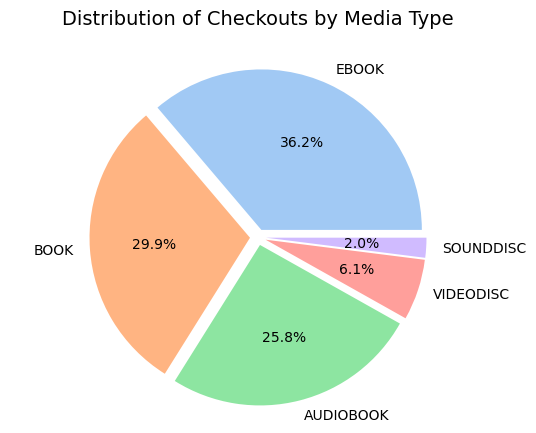

In [3]:
import boto3
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns 

# get information about the table
s3_tables_client = boto3.client('s3tables')
tbs = s3_tables_client.list_table_buckets(prefix=table_name)
tb = tbs['tableBuckets'][0]

s3_tables_arn = tb['arn']

table_bucket = s3_tables_client.get_table(tableBucketARN=s3_tables_arn, namespace=namespace, name=table_name)
metadata_location = table_bucket['metadataLocation']
aws_region = s3_tables_arn.split(':')[3]

con = duckdb.connect(database=':memory:', read_only=False)

# install plugins, load, then setup aws credentials information
setup_sql = f"""
INSTALL iceberg;
INSTALL aws;
INSTALL httpfs;

LOAD iceberg;
LOAD aws;
LOAD httpfs;

CREATE SECRET (
    TYPE s3,
    PROVIDER credential_chain,
    ENDPOINT 's3.{aws_region}.amazonaws.com'
);
"""
con.execute(setup_sql)

# fetch data from S3 Tables
s3tables_df = con.execute(f"SELECT * FROM iceberg_scan('{metadata_location}');").fetchdf()
# display(s3tables_df.head(5))

# run a query against the data
aggregation_df = s3tables_df.groupby('materialtype').agg(
    total_records=('materialtype', 'count'),
    total_checkouts=('checkouts', 'sum')
).sort_values('total_checkouts', ascending=False).reset_index().nlargest(5, "total_checkouts")

plt.pie(aggregation_df['total_checkouts'], 
        labels=aggregation_df['materialtype'],
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel'),
        explode=[0.05] * 5
       )
plt.axis('equal')
plt.title('Distribution of Checkouts by Media Type', pad=20, size=14)
plt.show()


# S3 Tables Maintenance

Let's look at S3 Tables optimizations tasks. S3 Tables' continual table optimization automatically scans and rewrites table data in the background.

In [15]:
# split dataframe, then append to the table
dfs = library_checkout.randomSplit([1.0] * 10)
for df in dfs:
    df.writeTo(full_table_name).using("Iceberg").append()


<Axes: xlabel='category', ylabel='Number of entities'>

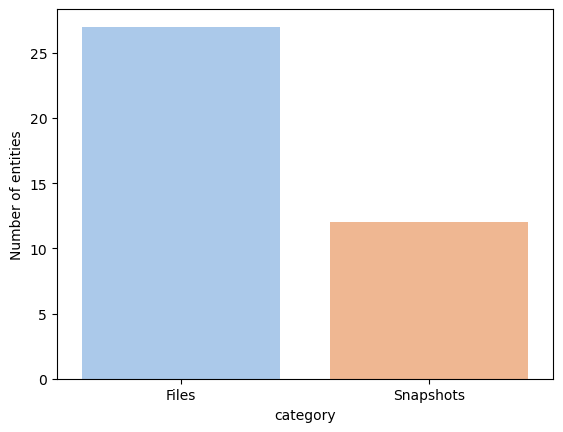

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

fdf = spark.sql("SELECT * FROM s3tablesbucket.demo.demo.files")
sdf = spark.sql("SELECT * FROM s3tablesbucket.demo.demo.snapshots")
df = pd.DataFrame({'category': ['Files', 'Snapshots'], 'Count': [fdf.count(), sdf.count()]})
display(sns.barplot(data=df, x='category', y='Count', palette='pastel', hue='category'))


## Automatic maintenance

Once S3 Tables maintenance tasks run, we observe reduced number of files due to compaction.

You can get the status and configurations of maintenance tasks by running the following command:

```bash
aws s3tables get-table-maintenance-job-status --table-bucket-arn arn:aws:s3tables:us-west-2:ACC:bucket/demo --namespace demo --name demo
```

Example output:

```json
{
    "tableARN": "arn:aws:s3tables:us-west-2:ACC:bucket/demo/table/415f4796-36de",
    "status": {
        "icebergCompaction": {
            "status": "Successful",
            "lastRunTimestamp": "2025-03-03T07:26:40.624000+00:00"
        },
        "icebergUnreferencedFileRemoval": {
            "status": "Successful",
            "lastRunTimestamp": "2025-03-02T19:27:13.823000+00:00"
        },
        "icebergSnapshotManagement": {
            "status": "Successful",
            "lastRunTimestamp": "2025-03-02T19:32:26.288000+00:00"
        }
    }
}
```

[2025-03-03 18:07:31,613] INFO @ line 161: NumExpr defaulting to 16 threads.


<Axes: xlabel='category', ylabel='Count'>

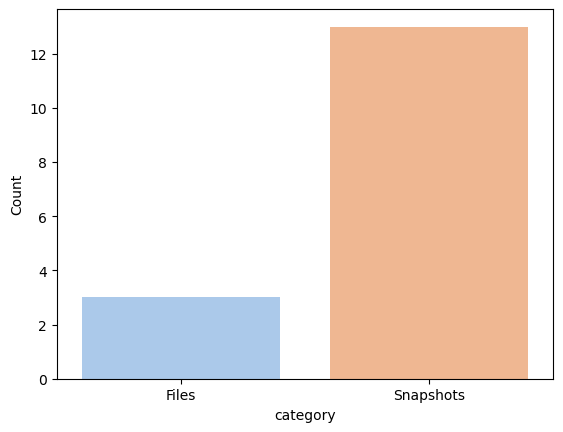

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

fdf = spark.sql("SELECT * FROM s3tablesbucket.demo.demo.files")
sdf = spark.sql("SELECT * FROM s3tablesbucket.demo.demo.snapshots")
df = pd.DataFrame({'category': ['Files', 'Snapshots'], 'Count': [fdf.count(), sdf.count()]})
display(sns.barplot(data=df, x='category', y='Count', palette='pastel', hue='category'))
